In [1]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
import joblib

import matplotlib.pyplot as plt
import math

from Model.Parabola import Parabola
from Model.Hyperbola import Hyperbola
from Model.Circular import Circular
from Model.RayPath import RayPath

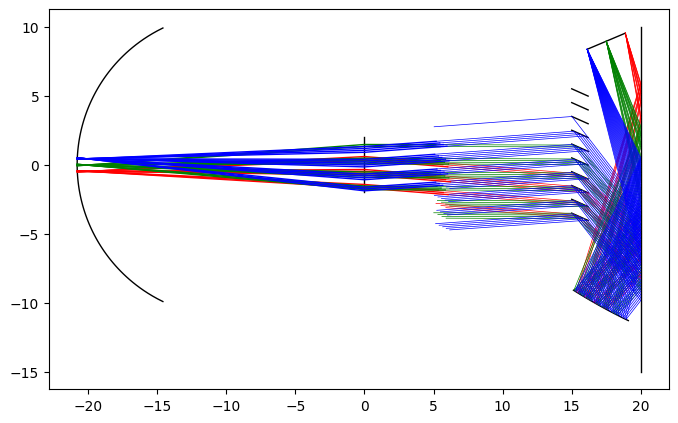

In [14]:
# set objects
OBJ_list = []

# Letinar PinTilt
# front plane
Z_module = 15
Z_thickness = 5
Y_module_top = 10
Y_module_length = 25
Pos_module_front_top = np.array([Z_module+Z_thickness, Y_module_top])
# pannel
W_pannel = 3
A_pannel = 0.4
X0_pannel = 0.5*Z_thickness/np.cos(A_pannel)
Vt_pannel = np.array([np.cos(A_pannel), np.sin(A_pannel)])
Vr_pannel = np.array([np.sin(A_pannel), -np.cos(A_pannel)])
# bottom mirror
F_bottom = 20
D_bottom = 1
Vn_bottom = np.array([-np.sin(A_pannel), -np.cos(A_pannel)])
Vt_bottom = np.array([np.cos(A_pannel), -np.sin(A_pannel)])
Pos_bottom_S = Pos_module_front_top + np.array([0, -F_bottom/np.cos(A_pannel)])   
Pos_bottom_O = Pos_bottom_S + D_bottom*Vt_bottom
# back plane
OBJ_list.append(Parabola(Pos_module_front_top, np.array([0, -1.0]), 0, Y_module_length))
OBJ_list[0].set_params(0, 0, 0)
# bottom mirror
OBJ_list.append(Parabola(Pos_bottom_O, Vt_bottom, -(Z_thickness + D_bottom)/np.cos(A_pannel), -1 - D_bottom))
OBJ_list[1].set_params(1/(4*F_bottom), 0, 0)
# pin mirror
N_mirror = 10
L_mirror = 1.3
A_mirror = 0.25*np.pi - 0.5*(2*A_pannel - np.arctan(0.5*X0_pannel/F_bottom))
H_mirror = 1
for i in range(N_mirror):
    OBJ_list.append(Parabola(np.array([Z_module, Y_module_top - 4.5 - i*H_mirror]), np.array([np.cos(A_mirror), -np.sin(A_mirror)]), 0, L_mirror))
    OBJ_list[-1].set_params(0, 0, 0)

# set pannel
# set rays
pixel_angle = np.linspace(-1, 0.5, 100)*25*np.pi/180 + 1*A_pannel

# red
pixel_x = X0_pannel - 0.5*W_pannel
pixel_origin = Pos_module_front_top - Vt_pannel*pixel_x
ray_list = []
for a in pixel_angle:
    ray_direction = np.array([math.sin(a), -math.cos(a)])
    ray_list.append(RayPath().calc_ray_path(pixel_origin, ray_direction, OBJ_list))

ray_plot_red = []
for ray in ray_list:
    if ray[-1,0]<(Z_module - 6):
        ray_plot_red.append(ray)

# green
pixel_x = X0_pannel
pixel_origin = Pos_module_front_top - Vt_pannel*pixel_x
ray_list = []
for a in pixel_angle:
    ray_direction = np.array([math.sin(a), -math.cos(a)])
    ray_list.append(RayPath().calc_ray_path(pixel_origin, ray_direction, OBJ_list))

ray_plot_green = []
for ray in ray_list:
    if ray[-1,0]<(Z_module - 6):
        ray_plot_green.append(ray)

# blue
pixel_x = X0_pannel + 0.5*W_pannel
pixel_origin = Pos_module_front_top - Vt_pannel*pixel_x
ray_list = []
for a in pixel_angle:
    ray_direction = np.array([math.sin(a), -math.cos(a)])
    ray_list.append(RayPath().calc_ray_path(pixel_origin, ray_direction, OBJ_list))

ray_plot_blue = []
for ray in ray_list:
    if ray[-1,0]<(Z_module - 6):# and ray[-1,1]<(Y_Pannel - 4.5):
        ray_plot_blue.append(ray)






# save the model to disk
filename = 'eye_model.joblib'

# Load the dictionary from the pickle file
loaded_dict = joblib.load(filename)
# Extract the model and PolynomialFeatures object from the dictionary
model = loaded_dict["model"]
poly = loaded_dict["poly"]

Eye_Params = loaded_dict["Eye_Params"]
Retina = Circular(np.array([-Eye_Params['eye_radius']-Eye_Params['iris_depth'], 0]), np.array([0, -1]), -0.9*Eye_Params['eye_radius'], 0.9*Eye_Params['eye_radius'])
Retina.set_params(Eye_Params['eye_radius'], 1)
Retina_plot = Retina.get_pos(100)
Pupil = Parabola(np.array([0, 0]), np.array([0, -1]), -1*Eye_Params['pupil_radius'], Eye_Params['pupil_radius'])
Pupil.set_params(0, 0, 0)
Pupil_plot = Pupil.get_pos(10)

# ray into pupil
# red
ray_list_hit_red = []
hit_y = []
hit_angle = []
for ray in ray_plot_red:
    dR = ray[-1] - ray[-2]
    U = dR/np.linalg.norm(dR)
    ray_obj = np.matmul(Pupil.rot, ray[-1] - Pupil.origin)
    U_obj = np.matmul(Pupil.rot, U)
    hit_obj, tangent_obj = RayPath().intersection(Pupil, ray_obj, U_obj)
    if len(hit_obj)==2:
        hit = np.matmul(Pupil.rot.T, hit_obj.reshape((2,1))).T[0] + Pupil.origin
        ray_list_hit_red.append(np.vstack((ray[-1], hit)))
        hit_y.append(hit[1])
        hit_angle.append(math.atan2(U[1], -U[0]))
#
X = np.array([np.array(hit_y).flatten(), np.array(hit_angle).flatten()]).T
X_poly = poly.fit_transform(X)
output_predicted = model.predict(X_poly)
for i in range(len(ray_list_hit_red)):
    ray = ray_list_hit_red[i][-1]
    U = np.array([-math.cos(output_predicted[i]), -math.sin(output_predicted[i])])
    ray_obj = np.matmul(Retina.rot, ray - Retina.origin)
    U_obj = np.matmul(Retina.rot, U)
    hit_obj, tangent_obj = RayPath().intersection(Retina, ray_obj, U_obj)
    if len(hit_obj)==2:
        hit = np.matmul(Retina.rot.T, hit_obj.reshape((2,1))).T[0] + Retina.origin
        ray_list_hit_red[i] = np.vstack((ray_list_hit_red[i], hit))

# green
ray_list_hit_green = []
hit_y = []
hit_angle = []
for ray in ray_plot_green:
    dR = ray[-1] - ray[-2]
    U = dR/np.linalg.norm(dR)
    ray_obj = np.matmul(Pupil.rot, ray[-1] - Pupil.origin)
    U_obj = np.matmul(Pupil.rot, U)
    hit_obj, tangent_obj = RayPath().intersection(Pupil, ray_obj, U_obj)
    if len(hit_obj)==2:
        hit = np.matmul(Pupil.rot.T, hit_obj.reshape((2,1))).T[0] + Pupil.origin
        ray_list_hit_green.append(np.vstack((ray[-1], hit)))
        hit_y.append(hit[1])
        hit_angle.append(math.atan2(U[1], -U[0]))
#
X = np.array([np.array(hit_y).flatten(), np.array(hit_angle).flatten()]).T
X_poly = poly.fit_transform(X)
output_predicted = model.predict(X_poly)
for i in range(len(ray_list_hit_green)):
    ray = ray_list_hit_green[i][-1]
    U = np.array([-math.cos(output_predicted[i]), -math.sin(output_predicted[i])])
    ray_obj = np.matmul(Retina.rot, ray - Retina.origin)
    U_obj = np.matmul(Retina.rot, U)
    hit_obj, tangent_obj = RayPath().intersection(Retina, ray_obj, U_obj)
    if len(hit_obj)==2:
        hit = np.matmul(Retina.rot.T, hit_obj.reshape((2,1))).T[0] + Retina.origin
        ray_list_hit_green[i] = np.vstack((ray_list_hit_green[i], hit))

# blue
ray_list_hit_blue = []
hit_y = []
hit_angle = []
for ray in ray_plot_blue:
    dR = ray[-1] - ray[-2]
    U = dR/np.linalg.norm(dR)
    ray_obj = np.matmul(Pupil.rot, ray[-1] - Pupil.origin)
    U_obj = np.matmul(Pupil.rot, U)
    hit_obj, tangent_obj = RayPath().intersection(Pupil, ray_obj, U_obj)
    if len(hit_obj)==2:
        hit = np.matmul(Pupil.rot.T, hit_obj.reshape((2,1))).T[0] + Pupil.origin
        ray_list_hit_blue.append(np.vstack((ray[-1], hit)))
        hit_y.append(hit[1])
        hit_angle.append(math.atan2(U[1], -U[0]))
#
X = np.array([np.array(hit_y).flatten(), np.array(hit_angle).flatten()]).T
X_poly = poly.fit_transform(X)
output_predicted = model.predict(X_poly)
for i in range(len(ray_list_hit_blue)):
    ray = ray_list_hit_blue[i][-1]
    U = np.array([-math.cos(output_predicted[i]), -math.sin(output_predicted[i])])
    ray_obj = np.matmul(Retina.rot, ray - Retina.origin)
    U_obj = np.matmul(Retina.rot, U)
    hit_obj, tangent_obj = RayPath().intersection(Retina, ray_obj, U_obj)
    if len(hit_obj)==2:
        hit = np.matmul(Retina.rot.T, hit_obj.reshape((2,1))).T[0] + Retina.origin
        ray_list_hit_blue[i] = np.vstack((ray_list_hit_blue[i], hit))


# plot
plt.figure(figsize=(8, 6))  # Set the figure size to 8 inches by 6 inches

# plot panels
plt.plot([Pos_module_front_top[0] - Vt_pannel[0]*(X0_pannel - 0.5*W_pannel), Pos_module_front_top[0] - Vt_pannel[0]*(X0_pannel + 0.5*W_pannel)],
         [Pos_module_front_top[1] - Vt_pannel[1]*(X0_pannel - 0.5*W_pannel), Pos_module_front_top[1] - Vt_pannel[1]*(X0_pannel + 0.5*W_pannel)]
         , 'k', linewidth=1)
# plot objects
for i in range(len(OBJ_list)):
    pn = 100
    px = np.linspace(OBJ_list[i].x1, OBJ_list[i].x2, pn)
    py = OBJ_list[i].y(px)
    pp = np.array([px, py])
    pplot = np.matmul(OBJ_list[i].rot.T, pp) + OBJ_list[i].origin.reshape(2,1)
    plt.plot(pplot[0], pplot[1], 'k', linewidth=1)

# plot rays
for ray in ray_plot_red:
    plt.plot(ray[:,0], ray[:,1], 'r', linewidth=0.5)
for ray in ray_plot_green:
    plt.plot(ray[:,0], ray[:,1], 'g', linewidth=0.5)
for ray in ray_plot_blue:
    plt.plot(ray[:,0], ray[:,1], 'b', linewidth=0.5)

plt.plot(Pupil_plot[0], Pupil_plot[1], 'k', linewidth=1)
plt.plot(Retina_plot[0], Retina_plot[1], 'k', linewidth=1)
for ray in ray_list_hit_red:
    plt.plot(ray[:,0], ray[:,1], 'r', linewidth=1)
for ray in ray_list_hit_green:
    plt.plot(ray[:,0], ray[:,1], 'g', linewidth=1)
for ray in ray_list_hit_blue:
    plt.plot(ray[:,0], ray[:,1], 'b', linewidth=1)
plt.gca().set_aspect(1)
plt.show()

